# Libraries | Install

In [10]:
!pip install torch sklearn numpy matplotlib tqdm torchviz ann_visualizer torchsummary tensorboard --quiet

You should consider upgrading via the '/Users/fermibot/PycharmProjects/python-projects/venv/bin/python -m pip install --upgrade pip' command.


# Libraries | Import

In [11]:
import torch
from sklearn.linear_model import LinearRegression
from random import random, randint, choice, normalvariate
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchviz import make_dot
from torchsummary import summary
import pandas as pd

# Functions | Define

In [12]:
def randomize(factor):
    return choice([-1, 1]) * factor * random()


class Config:
    x_n = 10  # NUMBER OF INPUT VARIABLES
    lr = 0.01
    lrs = [0.01, 0.00001]
    epochs = 25
    split_train = 0.8
    shuffle = True
    batch_size = 64
    batch_sizes = [16, 64, 1024]
    device = torch.device("mps")
    size_x = 2 ** 14


def print_separator():
    print("\n" + "-" * 100)


config = Config()

# Dataset | Synthesize

$Y_j = \underset{i}{\Sigma} c_{ij}*x_{ij} \mid c_i = 0.1, 0.2, 0.3 ...$ \mid x_{ij} ~ N(0, 1)

In [13]:
x_n = config.x_n
coe = [0.1 * x for x in range(1, x_n + 1)]
print([round(x, 4) for x in coe])

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


<Axes: xlabel='6', ylabel='y'>

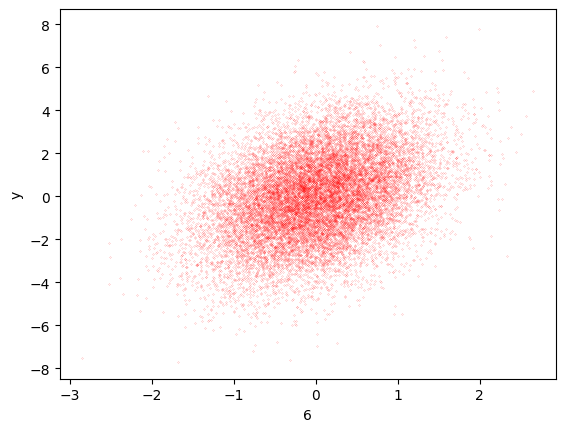

In [14]:
X = [[normalvariate() for coe_x in coe] for x in range(config.size_x)]
X_y = [[x_i * coe_j + randomize(0.01) for x_i, coe_j in zip(x, coe)] for x in X]
y = [sum([x_i * coe_j + randomize(0.01) for x_i, coe_j in zip(x, coe)]) for x in X]

df = pd.DataFrame(X_y)
df['y'] = y

df.plot.scatter(x=6, y='y', alpha=1, s=0.01, color='red')


# Modeling | Neural Networks

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from torch.utils.tensorboard import SummaryWriter

In [16]:
tensor_X = torch.tensor(X, dtype=torch.float32, device=config.device)
tensor_y = torch.tensor(y, dtype=torch.float32, device=config.device)

size_train = int(config.split_train * len(tensor_X))
size_test = len(tensor_X) - size_train
assert size_train + size_test == len(tensor_X)

dataset_train = TensorDataset(tensor_X[:size_train], tensor_y[:size_train])
dataset_test = TensorDataset(tensor_X[size_train:], tensor_y[size_train:])

In [17]:
class LinearModel(nn.Module):
    def __init__(self, in_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=in_features, out_features=1, bias=True)

    def forward(self, x):
        return self.linear(x)

## Modeling | Linear Regression | Neural Network | Train

In [18]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

for batch_size in config.batch_sizes:

    loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size)
    loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size)

    for lr in config.lrs:
        model = LinearModel(in_features=config.x_n)
        model.to(device=config.device)

        criterion = nn.MSELoss()
        optimizer = optim.SGD(model.parameters(), lr=lr)
        loss_all = []

        for epoch in tqdm(range(config.epochs)):
            # Training phase
            model.train()
            loss_epoch_train = 0.0
            for batch_X, batch_y in loader_train:
                batch_X, batch_y = batch_X.to(config.device), batch_y.to(config.device)

                optimizer.zero_grad()
                outputs = model(batch_X)
                loss_batch = criterion(outputs, batch_y.unsqueeze(1))
                loss_batch.backward()
                optimizer.step()

                loss_epoch_train += loss_batch.item()

            # Log training loss
            writer.add_scalar(f"Loss/batch_size_{batch_size}/Train/lr_{lr}", loss_epoch_train / len(loader_train),
                              epoch)

            # Evaluation phase
            model.eval()
            loss_epoch_test = 0.0
            all_preds = []
            all_targets = []

            with torch.no_grad():
                for batch_X, batch_y in loader_test:
                    batch_X, batch_y = batch_X.to(config.device), batch_y.to(config.device)
                    outputs = model(batch_X)
                    loss_batch = criterion(outputs, batch_y.unsqueeze(1))
                    loss_epoch_test += loss_batch.item()

                    all_preds.extend(outputs.cpu().numpy().flatten())
                    all_targets.extend(batch_y.cpu().numpy().flatten())

            # Log test loss
            avg_test_loss = loss_epoch_test / len(loader_test)
            writer.add_scalar(f"Loss/batch_size_{batch_size}/Test/lr_{lr}", avg_test_loss, epoch)

            # Calculate and log R2 score
            r2 = r2_score(all_targets, all_preds)
            writer.add_scalar(f"Metrics/batch_size_{batch_size}/R2/lr_{lr}", r2, epoch)

            # Log weights and biases for analysis
            writer.add_histogram(f"Weights/batch_size_{batch_size}/lr_{lr}", model.linear.weight, epoch)
            writer.add_histogram(f"Bias/batch_size_{batch_size}/lr_{lr}", model.linear.bias, epoch)

            # Log gradients (optional, for debugging)
            for name, param in model.named_parameters():
                if param.grad is not None:
                    writer.add_histogram(f"Gradients/batch_size_{batch_size}/{name}/lr_{lr}", param.grad, epoch)

    writer.close()


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

# Terminology

## Gradient
- $y = y(x)$
- where $x = (x_1, x_2, x_3) \implies y(x) = y(x_1, x_2, x_3)$
    - at a point in space $(x_1, x_2, x_3)$
- $\delta x = (\delta_{x_1}, \delta_{x_2}, \delta_{x_3})$ are the infinitesimal changes in $(x_1, x_2, x_3)$
- $y(x + \delta x) = y(x_1 + \delta_{x_1}, x_2 + \delta_{x_2}, x_3 + \delta_{x_3})$ is new a value of $y$
    - at a **new** point in space $(x_1 + \delta_{x_1}, x_2 + \delta_{x_2}, x_3 + \delta_{x_3})$
- $y(x_1 + \delta_{x_1}, x_2 + \delta_{x_2}, x_3 + \delta_{x_3}) = y + y'(x_1, x_2, x_3) \cdot (\delta_{x_1}, \delta_{x_2}, \delta_{x_3})
$


Short notation
- $y(x + \delta x) = y(x) + \delta y $
- $y(x + \delta x) = y(x) + y' \cdot \delta x$
- $y(x + \delta x) = y(x) +  \nabla y \cdot \delta x $
    - where $\nabla y$ is the gradient


### How is gradient used during training?
| x | y | slope |
| :- | :-: | -: |
| 1 | 2 | 2 |
| 2 | 2 | 1 |
| 3 | 3 | 1 |
| 4 | 5 | 1.25 |
| 5 | 5 | 1 |
| 6 | 6 | 1 |


## Epochs
- Number of times the entire dataset is passed through a model
- Example: If the data is passed through the ML 10 times during training, it means that 10 epochs have passed.

## Batch
- A small part of the dataset that is sent into the model at an instance
- Example: If a batch contains 64 observations, the batch size would be 64

## Learning Rate

- The factor of multiplier for the gradient
- If the learning rate is smaller, the model 'concludes' slower
- If the learning rate is larger, the model 'concludes' faster

## Loss
- Put in simple terms, loss is the amount of discrepancy between the model's prediction and the truth

In [59]:
# Loss example

x = [1, 2, 3, 4, 5, 6]
y = [2, 2, 3, 5, 5, 6]

slope = 1.2
loss = - sum([abs(yi - xi * slope) for xi, yi in zip(x, y)])
loss

-4.199999999999999


# Studies and Obvervations

We have used tensorboard during our demo. To launch tensorboard, run the following bash command after navigating to the directory that contains the log directory.

`cd python-projects/MachineLearning/MachineLearning_Hyperparameters` \
`tensorboard --logdir=runs`

After running the above command, you should be able to see the tensorboard visualization at [http://localhost:6006/](http://localhost:6006/)


## Study 01 | Learning Rate
- Effect of learning Rate on $R^2$ at a fixed batch size of 64
- Observations
    - When the learning rate is 0.00001, the model took a long time to get to the desired $R^2$.
    - When the learning rate is 0.01, the model achieved the desirable $R^2$ within one epoch.

- Effect of learning Rate on $Loss$ at a fixed batch size of 64
    - When the learning rate is 0.00001, the model took a long time to minimize the loss
    - When the learning rate is 0.01, the model got to nearly zero loss within one epoch.

## Study 02 | Batch Size
- Effect on batch size on $R^2$ for learning rate = 0.01
- Observations
    - When the batch size is 1024, the model took longer time to achieve the desired $R^2$.
    - When the batch size is 64, the model desired $R^2$ within 2 epochs.
- Effect on batch size on $Loss$ for learning rate = 0.01
    - When the batch size is 1024, it takes several epochs to minimize the loss to near zero
    - When the batch size is 64, the model minimized the loss to zero within an epoch
